# PyTorch Mastery — 2. Convolutional Neural Network (CNN)

Welcome! In this tutorial, we build a Convolutional Neural Network (CNN) for image classification on the CIFAR-10 dataset. CNNs excel at computer vision tasks by learning spatial hierarchies through convolution and pooling layers.

## Tutorial flow

1. Import libraries (PyTorch, torchvision)
2. Load and transform CIFAR-10 dataset
3. Create DataLoaders for batching
4. Visualize sample images
5. Understand Conv2D, pooling, and layer composition (with diagrams)
6. Define a CNN architecture
7. Set up loss and optimizer
8. Train the model
9. Evaluate test accuracy

Skim the code first, then read the explanatory markdown cells that follow each block.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import datasets, transforms

## Imports explained

- `torch`, `torch.nn`, `torch.optim`, `torch.nn.functional`: Core PyTorch for tensors, layers, optimizers, and activation functions.
- `torch.utils.data.TensorDataset, DataLoader, Dataset`: Tools for wrapping data and iterating in batches.
- `torchvision.datasets`: Pre-packaged datasets (MNIST, CIFAR-10, ImageNet, etc.).
- `torchvision.transforms`: Image preprocessing (resize, normalize, augment, convert to tensor).

In [2]:
# Transform: Convert image to tensor and normalize (0–1 range)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # normalize to mean=0.5, std=0.5
])

# Download MNIST training & test datasets
train_dataset = datasets.CIFAR10(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, transform=transform, download=True
)

## Load CIFAR-10 dataset with transforms

**CIFAR-10**: 60,000 32×32 color images in 10 classes (airplane, car, bird, cat, deer, dog, frog, horse, ship, truck); 50k train, 10k test.

**Transforms**:
- `transforms.ToTensor()`: Converts PIL image or NumPy array (H×W×C, [0, 255]) to PyTorch tensor (C×H×W, [0.0, 1.0]).
- `transforms.Normalize((0.5,), (0.5,))`: Applies `(pixel - mean) / std` per channel. Here mean=0.5, std=0.5 → pixel range becomes [-1, 1].
  - Note: CIFAR-10 is RGB (3 channels), so ideally use `(0.5, 0.5, 0.5)` for mean and std. Using `(0.5,)` works but only normalizes the first channel properly; update to 3-tuple for consistency.

**datasets.CIFAR10**:
- `root='./data'`: directory to store downloaded files.
- `train=True/False`: load train or test split.
- `transform=transform`: apply transforms on-the-fly when loading each image.
- `download=True`: auto-download if not present.

In [3]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Create DataLoaders

- `DataLoader(dataset, batch_size=64, shuffle=True)`: wraps a dataset and yields batches.
  - `batch_size=64`: each iteration returns 64 images and 64 labels.
  - `shuffle=True` (train): randomizes order each epoch → better generalization.
  - `shuffle=False` (test): consistent evaluation order.
- DataLoader automatically handles multi-processing (set `num_workers` for speed on multi-core systems).

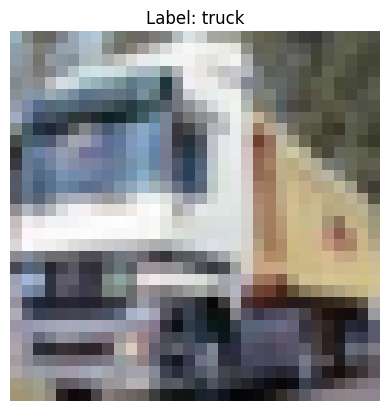

In [4]:
import numpy as np

import matplotlib.pyplot as plt

# CIFAR10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get a sample from the dataset
image, label = train_dataset[1]

# Denormalize the image (reverse the normalization)
image = image / 2 + 0.5

# Convert tensor to numpy and transpose from (C, H, W) to (H, W, C)
image = image.numpy().transpose(1, 2, 0)

# Display the image
plt.imshow(image)
plt.title(f'Label: {classes[label]}')
plt.axis('off')
plt.show()

## Visualize a single sample image

- `train_dataset[1]`: returns `(image_tensor, label)`.
- `image / 2 + 0.5`: reverses the normalization `(x - 0.5) / 0.5` → brings pixel values back to [0, 1].
- `.numpy().transpose(1, 2, 0)`: converts from PyTorch's (C, H, W) to Matplotlib's (H, W, C).
- `plt.imshow()`: displays the RGB image.
- `classes[label]`: maps integer label to human-readable class name.

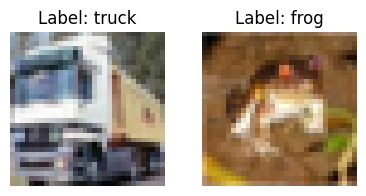

In [5]:
# Set the height for the images
height = 2  # Adjust the height as needed

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(4, height))

# Display the first image
axes[0].imshow(image)
axes[0].set_title(f'Label: {classes[label]}')
axes[0].axis('off')  # Hide axes

# Display another sample image from the dataset (for example, the first image)
image2, label2 = train_dataset[0]
image2 = image2 / 2 + 0.5  # Denormalize
image2 = image2.numpy().transpose(1, 2, 0)

# Display the second image
axes[1].imshow(image2)
axes[1].set_title(f'Label: {classes[label2]}')
axes[1].axis('off')  # Hide axes

# Show the plot
plt.tight_layout()
plt.show()

## Understanding Convolutional Layers: Visual Guide

Before diving into the code, let's understand the key concepts of convolutional layers through visual diagrams. These illustrations show how Conv2D operations work with different parameters:

### What you'll learn from these diagrams:

1. **Basic 2D Convolution**: How a small kernel (filter) slides across an image to detect features
2. **Multi-channel Convolution**: How CNNs process RGB images (or feature maps with multiple channels)
3. **Padding**: Why and how we add borders of zeros to control output dimensions
4. **Grouped Convolutions**: An efficient variant that splits channels into independent groups
5. **Pooling Operations**: Different pooling strategies (max, average, etc.) for downsampling

These visual concepts are critical for understanding the `ConvNet` class we'll build next!

<figure>
  <img src="asset/conv2d.png" alt="2D convolution" width="520">
  <figcaption>2D conv: a 3×3 kernel slides over H×W; stride/padding control output size.</figcaption>
</figure>

<figure>
  <img src="asset/conv2d_multi_channel.png" alt="Multi-channel conv" width="520">
  <figcaption>Multi‑channel: each filter spans all input channels; outputs sum across channels.</figcaption>
</figure>

<figure>
  <img src="asset/padding.png" alt="Padding" width="520">
  <figcaption>Padding: add zeros around borders; e.g., pad=1 with 3×3 keeps spatial size (“same”).</figcaption>
</figure>

<figure>
  <img src="asset/group.png" alt="Grouped conv" width="520">
  <figcaption>Groups: split channels into groups; depthwise conv uses groups=in_channels.</figcaption>
</figure>
<figure>
  <img src="asset/image.png" alt="Grouped conv" width="520">
  <figcaption>Different Pooling Layers Applied</figcaption>
</figure>

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3,out_channels=16, kernel_size=3, padding=1)  # Input channels=3 for RGB
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling
        self.conv2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128) # calculate flattened size by printing shape after conv and pool layers
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for CIFAR-10
        self.relu=nn.ReLU()
        
    def forward(self, x):
        x=self.pool(self.relu(self.conv1(x)))
        x=self.pool(self.relu(self.conv2(x)))
        x=x.view(-1, 32*8*8)
        x=self.relu(self.fc1(x))
        x=self.relu(self.fc2(x))
        

        return x
        

## Define the CNN architecture (`ConvNet`)

### Layers breakdown

**Convolutional layers**:
- `nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)`:
  - `in_channels=3`: RGB input (3 color channels).
  - `out_channels=16`: produces 16 feature maps (each filter learns different patterns like edges, textures).
  - `kernel_size=3`: 3×3 filter slides over the image.
  - `padding=1`: adds 1 pixel of zeros around borders → keeps spatial size same when stride=1.
  - Output size formula: `(H + 2×padding - kernel_size) / stride + 1`.  
    With padding=1, kernel=3, stride=1: (32 + 2 - 3)/1 + 1 = 32 → output is 32×32×16.

- `nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)`: second conv increases depth to 32 feature maps.

**Pooling layer**:
- `nn.MaxPool2d(2, 2)`: 2×2 max pooling with stride=2.
  - Takes max value in each 2×2 window → reduces spatial size by half.
  - After first pool: 32×32 → 16×16; after second pool: 16×16 → 8×8.
  - Pooling provides translation invariance and reduces parameters.

**Fully connected (linear) layers**:
- `nn.Linear(32 * 8 * 8, 128)`: flattens 32×8×8 = 2048 features into a vector, then maps to 128 hidden units.
- `nn.Linear(128, 10)`: maps 128 → 10 output logits (one per CIFAR-10 class).

**Activation**:
- `nn.ReLU()`: applies `max(0, x)` for non-linearity; enables learning complex patterns.

### Forward pass flow

1. **Input**: (batch_size, 3, 32, 32) — RGB images
2. **conv1 → ReLU → pool**: (N, 3, 32, 32) → (N, 16, 32, 32) → (N, 16, 16, 16)
3. **conv2 → ReLU → pool**: (N, 16, 16, 16) → (N, 32, 16, 16) → (N, 32, 8, 8)
4. **Flatten**: (N, 32, 8, 8) → (N, 2048) using `.view(-1, 32*8*8)`
5. **fc1 → ReLU**: (N, 2048) → (N, 128)
6. **fc2** (no activation): (N, 128) → (N, 10) logits for CrossEntropyLoss

**Important note**: The last `ReLU` on fc2 in the code (`x=self.relu(self.fc2(x))`) is **incorrect**. Remove it—CrossEntropyLoss expects raw logits. The correct last line should be:
```python
x = self.fc2(x)  # no ReLU here
return x
```

<figure>
  <img src="asset/understand_conv2linear.png" alt="Grouped conv" width="520">
  <figcaption>This is a simple method. In the forward pass, only code till pool layer. Then send random model and see what is the final output. This output shape we will just copy paste into the ``fc layer `` so that the conversion occurs without error</figcaption>
</figure>


### 1. **Match Kernel, Stride, and Padding to Image Scale**

* **Small images (e.g., 32×32 like CIFAR-10):**

  * Use **smaller kernels (3×3)** and **padding=1** to preserve spatial dimensions longer.
  * Use **stride=1** in early layers to capture fine details.
  * Too many pooling/stride layers will shrink your feature maps too fast.
* **Large images (e.g., 224×224 like ImageNet):**

  * You can start with **larger kernels (7×7 or 5×5)** and a stride of 2 to downsample faster.

**Rule of thumb:**
Preserve more spatial resolution early → go deeper → downsample later.


### 2. **Gradually Increase Filters**

* Early layers detect edges and textures → fewer filters (e.g., 16 or 32).
* Deeper layers detect complex shapes → more filters (e.g., 64, 128, 256…).

Example:

```
Conv2d(3, 32, 3) → Conv2d(32, 64, 3) → Conv2d(64, 128, 3)
```

This gives the model hierarchical feature richness.


### 3. **Use Pooling Sparingly**

* Pooling (e.g., MaxPool2d(2,2)) reduces size but also loses information.
* Too much pooling on small images will destroy detail.
* Instead of multiple pooling layers, sometimes you can use **stride=2** in later convs to learn downsampling.

Example:
For CIFAR-10 (32×32):

* 2 pool layers → output ≈ 8×8 → perfect for flattening.


### 4. **Compute Flattened Size Properly**

* Always check output shape after convolutions and pooling before `fc1`.

```python
print(x.shape)
```

If you miscalculate, you’ll get shape errors like “mat1 and mat2 shapes cannot be multiplied.”

For CIFAR-10:
After two (2×2) poolings on 32×32 → (32 / 4) = 8 → `32 * 8 * 8`.



### 5. **Add Normalization and Dropout**

* Add **BatchNorm2d** after each convolution → stabilizes training.
* Add **Dropout** after ReLU or between dense layers → prevents overfitting.

Example:

```python
self.bn1 = nn.BatchNorm2d(16)
self.dropout = nn.Dropout(0.5)
```


### 6. **Activation Choices**

* **ReLU** is standard for speed and simplicity.
* Try **LeakyReLU** or **GELU** for deeper models or small datasets to avoid dead neurons.


### 7. **Keep Output Layer Logical**

* Number of neurons in final `fc2` = number of classes (e.g., 10 for CIFAR-10).
* Don’t apply ReLU after final output if you’re using `CrossEntropyLoss` (it already includes `Softmax` internally).

### 8. **Monitor Overfitting**

* If validation accuracy stagnates while training accuracy increases → too many parameters.
* Reduce `fc` layer size, add dropout, or use data augmentation.


### Summary Rule Set

| Image Size         | Kernel        | Filters Progression | Pooling             | Tips                       |
| ------------------ | ------------- | ------------------- | ------------------- | -------------------------- |
| 32×32 (CIFAR-10)   | 3×3           | 16→32→64            | MaxPool(2,2) twice  | Avoid too deep nets        |
| 64×64              | 3×3 or 5×5    | 32→64→128           | MaxPool(2,2) thrice | Use dropout                |
| 224×224 (ImageNet) | 7×7, then 3×3 | 64→128→256→512      | Stride & Pool       | Use BatchNorm, deeper nets |



###  **How filters make an impact**

Each **filter** (or kernel) in a convolutional layer looks for a specific **pattern** in the image.

* The first filters usually detect **basic shapes** — like edges or corners.
* As you go deeper, filters combine those patterns into **bigger features** — like eyes, wheels, or textures.
* The more filters you have, the **more types of features** the model can learn.

But there’s a tradeoff:

* More filters → more patterns learned, but also more **computation and risk of overfitting** (especially with small datasets).
  So you increase filters gradually across layers, not all at once.

Example:

```
Conv1: 16 filters  → learns simple edges  
Conv2: 32 filters → learns small shapes  
Conv3: 64 filters → learns complex structures
```



### **Using pooling layers carefully**

Pooling layers (like `MaxPool2d`) reduce image size. This helps the model learn **faster** and use **less memory**, but it also removes some details.

If you use **too many pooling layers** (or use them too early), the image becomes too small too quickly, and you lose useful information — for example, small features that matter for classification.

So “using pooling carefully” means:

* Don’t add a pooling layer after every convolution unless needed.
* On **small images (like 32×32)**, 2 pooling layers are usually enough.
* On **large images**, you can use more pooling or stride to reduce size faster.

Example:
CIFAR-10 (32×32)

```
Conv → Pool → Conv → Pool → Flatten → FC
```

That gives you 8×8 feature maps — enough detail left for the dense layers.


In short:

* Filters decide **what patterns** the network learns.
* Pooling decides **how much detail** the network keeps.
  You want enough filters to learn variety, and enough resolution (not over-pooled) to keep useful information.



### **Every 2–3 convolution layers → one pooling layer**

That’s the most common spacing.
It lets the network extract richer features before reducing size.

Example pattern:

```
Conv → ReLU  
Conv → ReLU  
Pool  
Conv → ReLU  
Conv → ReLU  
Pool
```

Here, two conv layers learn details at the same resolution before pooling shrinks the image.



### **Why not after every conv?**

If you pool too soon, you’ll lose important details before the model learns to recognize them.
If your image is small (like 32×32), just two poolings can already reduce it to 8×8 — that’s enough.



### **Rule of thumb by image size:**

| Image size         | Good pooling gap      | Example                           |
| ------------------ | --------------------- | --------------------------------- |
| 32×32 (CIFAR-10)   | Every 2 conv layers   | 2 pooling layers total            |
| 64×64              | Every 2 conv layers   | 2–3 pooling layers                |
| 224×224 (ImageNet) | Every 2–3 conv layers | 4–5 pooling or stride downsamples |



### **Alternative to frequent pooling**

Instead of pooling too often, you can:

* Use **stride=2** in some conv layers to downsample gradually.
* Use **global average pooling** before the final dense layer instead of flattening a large tensor.



**In short:**
Add a pooling layer **after every 2–3 conv layers**, depending on image size.
You want to **extract features first**, then **reduce size** — not the other way around.


In [7]:
model=ConvNet()
print(model)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


## Instantiate the model

- `model = ConvNet()`: creates an instance of the CNN.
- `print(model)`: displays the layer hierarchy and parameter counts (useful for debugging architecture).

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10


## Loss function and optimizer

- `nn.CrossEntropyLoss()`:
  - Combines `LogSoftmax` + `NLLLoss` for multi-class classification.
  - Expects:
    - **Input (logits)**: shape (N, num_classes), dtype float32.
    - **Target**: shape (N,), dtype int64, values in [0, num_classes-1].
  - Automatically applies softmax internally; don't apply it in your model's forward.
  
- `optim.Adam(model.parameters(), lr=0.001)`:
  - Adam optimizer: adaptive learning rates per parameter (momentum + RMSProp).
  - `lr=0.001`: learning rate; controls step size in weight updates.
  
- `epochs = 10`: number of full passes through the training set.

In [9]:
for epoch in range(10):  # loop over the dataset multiple times
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print('Finished Training')

Epoch [1/10], Loss: 1.9503
Epoch [2/10], Loss: 1.7221
Epoch [3/10], Loss: 1.6037
Epoch [4/10], Loss: 1.9055
Epoch [5/10], Loss: 1.6187
Epoch [6/10], Loss: 0.6906
Epoch [7/10], Loss: 0.9529
Epoch [8/10], Loss: 0.9014
Epoch [9/10], Loss: 0.8625
Epoch [10/10], Loss: 0.4569
Finished Training


## Training loop

**Epoch loop**: runs 10 times over the entire training dataset.

**Batch loop**: iterates through mini-batches of 64 images.

**Training steps per batch**:
1. `optimizer.zero_grad()`: clears old gradients from previous iteration (PyTorch accumulates gradients by default).
2. `outputs = model(inputs)`: forward pass → computes logits (N, 10).
3. `loss = criterion(outputs, labels)`: computes cross-entropy loss.
4. `loss.backward()`: backpropagation → computes gradients of loss w.r.t. all parameters.
5. `optimizer.step()`: updates weights using gradients: `weight = weight - lr * gradient`.

**Print**: shows loss for the last batch of each epoch (better: track average loss per epoch by summing and dividing by `len(train_loader)`).

In [10]:
model.eval()

correct=0
total=0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 63.65%


## Evaluate on the test set

**Steps**:
1. `model.eval()`: sets model to evaluation mode (disables dropout, fixes batch norm stats if present).
2. `torch.no_grad()`: disables gradient computation → saves memory and speeds up inference.
3. For each batch:
   - `outputs = model(X_batch)`: forward pass → (N, 10) logits.
   - `torch.max(outputs, 1)`: returns (max_values, indices) along dim=1 → `predicted` holds class indices with highest logit.
   - `total += y_batch.size(0)`: count samples.
   - `correct += (predicted == y_batch).sum().item()`: count correct predictions.
4. **Accuracy** = (correct / total) × 100.

**Note**: This is top-1 accuracy. For deeper analysis, compute confusion matrix, per-class precision/recall, or top-5 accuracy.

## Summary and next steps

You've built a simple CNN for CIFAR-10 image classification! Key concepts covered:

- **Conv2d**: learns spatial features via small kernels sliding over images.
- **MaxPool2d**: downsamples spatial dimensions, reduces parameters, adds translation invariance.
- **Flatten**: converts 4D (N, C, H, W) feature maps to 2D (N, features) for fully connected layers.
- **CrossEntropyLoss**: combines softmax + negative log-likelihood for multi-class problems.
- **Training loop**: zero_grad → forward → loss → backward → step.
- **Evaluation**: model.eval() + no_grad() for inference.

### Improvements to try

1. **Fix the last ReLU**: Remove `self.relu(self.fc2(x))` → use `self.fc2(x)` directly. CrossEntropyLoss expects logits, not activated outputs.

2. **Better normalization**: Update transform to 3-channel mean/std:
   ```python
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
   # CIFAR-10 dataset-specific statistics
   ```

3. **Track average loss per epoch**: Instead of printing the last batch loss, sum all losses and divide by `len(train_loader)`.

4. **Add more conv layers**: Stack 3–4 conv blocks with increasing channels (16→32→64→128) for deeper feature extraction.

5. **Data augmentation**: Add `transforms.RandomHorizontalFlip()`, `transforms.RandomCrop(32, padding=4)` to reduce overfitting.

6. **Batch normalization**: Insert `nn.BatchNorm2d(channels)` after each conv to stabilize training.

7. **Dropout**: Add `nn.Dropout(0.5)` before fc layers to prevent overfitting.

8. **Learning rate scheduler**: Use `torch.optim.lr_scheduler.StepLR` to decay learning rate over epochs.

9. **Save/load model**: Use `torch.save(model.state_dict(), 'cifar_cnn.pth')` to save trained weights.

10. **Visualize feature maps**: Extract intermediate conv outputs and plot them to see what patterns the network learned.

### Architecture evolution

- **LeNet** (1998): pioneered CNNs for digit recognition.
- **AlexNet** (2012): deeper, ReLU, dropout → ImageNet breakthrough.
- **VGG** (2014): uniform 3×3 convs, very deep (16–19 layers).
- **ResNet** (2015): skip connections enable 100+ layers.
- **EfficientNet** (2019): compound scaling (width × depth × resolution).

Try implementing VGG-like blocks or ResNet skip connections next!